# Setup

In [1]:
# import packages
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch_compmem/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch_compmem/neurosketch_voxelmat_freesurfer_drawing'
path_to_recog = '/home/jgunn/neurosketch/recmatrices'
path_to_draw = '/home/jgunn/neurosketch/drawmatrices' 
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG'])
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])

## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [3]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [4]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#sub_list = [s for s in sub_list if s != '1207162']
print('Number of subs: {}'.format(len(sub_list)))

Number of subs: 31


In [5]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [6]:
#### Helper data loader functions
def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

def flatten(x):
    return [item for sublist in x for item in sublist]

def get_prob_timecourse(iv,DM,version='4way'):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    if version=='4way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        c1 = control_objs[0]
        c2 = control_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
    elif version=='3way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c_prob'].mean().values)).mean(0) ## control timecourse
        
    elif version=='2way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        
        control = np.zeros(len(foil)) 
        
    return target, foil, control

In [7]:
version = '4way'
tag = 'logged'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
#ALLDM = pd.read_csv('./formatted_partial_sketch.csv')
ALLDM = cleanup_df(ALLDM)

# Implementation

Here's the plan. For each ROI...
1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

In [8]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-iv matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
# 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
variants = ['t', 'f', 't-f', 'c']
ivs = ['run_num','trial_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for variant in variants:
        for this_roi in roi_list:

            # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
            # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
            scores = []

            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])

                if variant == 't':
                    score = t
                elif variant == 'f':
                    score = f
                elif variant == 'c':
                    score = c
                else:
                    score = t-f

                if len(scores) == 0:
                    scores = score
                else:
                    scores = np.vstack((scores, score))

            # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
            # in the same order as they are in the matrix.
            recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
            # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
            # and the prepost change vector is the time course we're looking to understand for this ROI.
            corcourse = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]
            #corcourse = [np.mean(scores[:,i]) for i in range(np.shape(scores)[1])]
            r,p = stats.pearsonr(np.arange(np.shape(scores)[1]),corcourse)

            fig = plt.figure(figsize=(8,4))
            plt.plot(corcourse, 'ro', label='data')
            #sns.regplot(x=np.arange(len(corcourse)), y=np.array(corcourse))
            plt.axhline(y=0.0,linestyle='dashed')
            plt.ylim((-.6,.6))
            plt.ylabel('corr({}, prepost_difference)'.format(variant))
            plt.xlabel(this_iv)
            plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))

            if not os.path.exists('./plots/roi/drawrecogcourse'):
                os.makedirs('./plots/roi/drawrecogcourse')
            plt.tight_layout()
            plt.savefig('./plots/roi/drawrecogcourse/draw_recog_course_{}_{}_{}.pdf'.format(this_roi,this_iv,variant))
            plt.close(fig)
            #plt.show()

Let's try a variant that plots t and f correlations with prepost separately/on the same graph.

In [9]:
subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
ivs = ['run_num','trial_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for this_roi in roi_list:

        # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
        # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
        T = []
        F = []
        C = []

        for sub in subs:
            inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            num_ivs = len(t)

            if len(T) == 0:
                T = t
                F = f
                C = c
                DTF = t-f
            else:
                T = np.vstack((T,t))
                F = np.vstack((F,f))
                C = np.vstack((C,c))
                DTF = np.vstack((DTF,t-f))

        # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
        # in the same order as they are in the matrix.
        recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values

        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.

        fig = plt.figure(figsize=(8,4))

        corcourse = [stats.pearsonr(T[:,i],recog)[0] for i in range(num_ivs)]
        #corcourse = [np.mean(T[:,i]) for i in range(num_ivs)]
        meanT = np.mean(np.array(corcourse))
        r,p = stats.pearsonr(np.arange(num_ivs),corcourse)
        plt.plot(corcourse, 'ro', label='target')
        plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'r')

        corcourse = [stats.pearsonr(F[:,i],recog)[0] for i in range(num_ivs)]
        #corcourse = [np.mean(F[:,i]) for i in range(num_ivs)]
        meanF = np.mean(np.array(corcourse))
        r,p = stats.pearsonr(np.arange(num_ivs),corcourse)
        plt.plot(corcourse, 'cv', label='competitor')
        plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'c')

        plt.ylabel('corr({}, prepost_difference)'.format(variant))
        plt.xlabel(this_iv)
        plt.title('ROI: {}  mean(t): {}  mean(f): {}'.format(this_roi, meanT, meanF))
        plt.legend()

        if not os.path.exists('./plots/roi/drawrecogcourse'):
            os.makedirs('./plots/roi/drawrecogcourse')
        plt.tight_layout()
        plt.savefig('./plots/roi/drawrecogcourse/draw_recog_course_{}_{}.pdf'.format(this_roi, this_iv))
        plt.close(fig)

Let's try redo-ing the original draw_contrast vs prepost differentiation analysis focusing the target and competitor scores.

In [10]:
sub_tf = []
sub_tc = []
sub_fc = []
roi = []
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))

subs = np.unique(ALLDM.subj.values)
ivs = ['time_point'] ## other options 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds],version=version)
#             t,f,c = get_prob_timecourse_alt(this_iv,ALLDM[inds])                    
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f               
                DTC = t
                DFC = f
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t))
                DFC = np.hstack((DFC,f))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='target-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='target-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['target-foil','target-control','foil-control','roi']
d = d.astype({'target-foil':'float64','target-control':'float64','foil-control':'float64'})

In [11]:
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for spec in ['target-control', 'foil-control']:
    for this_roi in roi_list:
    #     draw = d[d['roi']==this_roi]['target-control'].values - d[d['roi']==this_roi]['foil-control'].values
        draw = d[d['roi']==this_roi][spec].values
        recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
    #     recog = prepost['tradiff_{}'.format(this_roi)].values

        z = pd.DataFrame([draw,recog])
        z = z.transpose()
        z.columns=['draw','recog']

        ## plot 
        fig = plt.figure(figsize=(6,6))
        sns.set_context('poster')
        sns.regplot(x="draw",
                    y ="recog",
                    data=z)
        r,p = stats.pearsonr(draw,recog)
        plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
        plt.xlabel('drawing: {}'.format(spec[:spec.find('-')]))
        plt.ylabel('recog: post-pre differentiation')
        if not os.path.exists('./plots/roi/drawrecog'):
            os.makedirs('./plots/roi/drawrecog')
        plt.tight_layout()
        plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}_{}.pdf'.format(this_roi, spec[:spec.find('-')]))
        plt.close(fig)    

bar plot

In [ ]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-trial_num matrix for each clf where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. The vector defined by taking the `stats.pearsonr()` between each corresponding pair of numTrials-length rows of the two subject-by-trial_num matrices is what we're looking to plot. 

version = '4way'
tag = 'logged'

drawrecogDM = cleanup_df(pd.read_csv('/home/jgunn/neurosketch/logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)))
partialsketchDM = pd.read_csv('/home/jgunn/neurosketch/formatted_partial_sketch.csv')

numTrials = 20

# some subjects missing in prepost
missing_subj = np.setdiff1d(np.unique(partialsketchDM['subj']), drawrecogDM['subj'])
mask = partialsketchDM['subj'].isin(missing_subj)
partialsketchDM = partialsketchDM[~mask]
partialsketchDM.sort_values('subj')
subs = np.unique(drawrecogDM.subj.values)

variants = ['t', 'f', 't-f', 'c']
corrsbyroi = []

for variant in variants:
    
    corrbyroi = []
    
    for this_roi in roi_list:

        # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
        # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
        scores_drawrecog = []

        for sub in subs:
            inds = (drawrecogDM['roi']==this_roi) & (drawrecogDM['subj']==sub) 
            t,f,c = get_prob_timecourse('trial_num',drawrecogDM[inds])

            if variant == 't':
                score = t
            elif variant == 'f':
                score = f
            elif variant == 'c':
                score = c
            else:
                score = t-f

            if len(scores_drawrecog) == 0:
                scores_drawrecog = score
            else:
                scores_drawrecog = np.vstack((scores_drawrecog, score))

        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.
        correlations = [stats.pearsonr(scores_drawrecog[i,:],scores_partialsketch[i,:])[0] for i in range(len(subs))]
        corrbyroi.append(correlations)
        
    corrbyroi = pd.DataFrame(corrbyroi).transpose()
    corrbyroi.columns = roi_formatted
    #sns.set_context('talk')
    plt.figure(figsize=(11,4))
    sns.barplot(data=corrbyroi,palette='husl',ci=95)
    plt.xlabel('ROIs')
    plt.title('Within Subject Comparison of {} Scores Between Clfs'.format(variant))
    plt.ylabel('Mean Trialwise Correlation B/t Classifiers')
    plt.ylim((-.2, .15))
    plt.show()
    
    #if not os.path.exists('./plots/roi/compare'):
    #    os.makedirs('./plots/roi/compare')
    #plt.tight_layout()
    #plt.savefig('./plots/roi/compare/comparecourse_{}_{}.pdf'.format(this_roi,variant))
    #plt.close(fig)

In [ ]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-trial_num matrix for each clf where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. The vector defined by taking the `stats.pearsonr()` between each corresponding pair of numTrials-length rows of the two subject-by-trial_num matrices is what we're looking to plot. 

version = '4way'
tag = 'logged'

drawrecogDM = cleanup_df(pd.read_csv('/home/jgunn/neurosketch/logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)))
partialsketchDM = pd.read_csv('/home/jgunn/neurosketch/formatted_partial_sketch.csv')

numTrials = 20

# some subjects missing in prepost
missing_subj = np.setdiff1d(np.unique(partialsketchDM['subj']), drawrecogDM['subj'])
mask = partialsketchDM['subj'].isin(missing_subj)
partialsketchDM = partialsketchDM[~mask]
partialsketchDM.sort_values('subj')
subs = np.unique(drawrecogDM.subj.values)

variants = ['t', 'f', 't-f', 'c']
corrsbyroi = []

for variant in variants:
    
    corrbyroi = []
    
    for this_roi in roi_list:

        scores = []

        for sub in subs:
            inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])

            if variant == 't':
                score = t
            elif variant == 'f':
                score = f
            elif variant == 'c':
                score = c
            else:
                score = t-f

            if len(scores) == 0:
                scores = score
            else:
                scores = np.vstack((scores, score))

        # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
        # in the same order as they are in the matrix.
        recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.
        corcourse = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]
        #corcourse = [np.mean(scores[:,i]) for i in range(np.shape(scores)[1])]
        r,p = stats.pearsonr(np.arange(np.shape(scores)[1]),corcourse)
        corrbyroi

        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.
        correlations = [stats.pearsonr(scores_drawrecog[i,:],scores_partialsketch[i,:])[0] for i in range(len(subs))]
        corrbyroi.append(correlations)
        
    corrbyroi = pd.DataFrame(corrbyroi).transpose()
    corrbyroi.columns = roi_formatted
    #sns.set_context('talk')
    plt.figure(figsize=(11,4))
    sns.barplot(data=corrbyroi,palette='husl',ci=95)
    plt.xlabel('ROIs')
    plt.title('Within Subject Comparison of {} Scores Between Clfs'.format(variant))
    plt.ylabel('Mean Trialwise Correlation B/t Classifiers')
    plt.ylim((-.2, .15))
    plt.show()
    

# Let's animate the score by prepost differentiation scatterplot. Produce the subject-by-iv matrix again, and then update the animation by plotting columns against prepost differentation in successive indices.

In [10]:
import random

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

subs = np.unique(ALLDM.subj.values)
colors = []
for i in range(len(subs)):
    colors.append(generate_new_color(colors))
colors = np.array(colors)

In [33]:
from matplotlib.animation import FuncAnimation
def animate(iv):
    ax.set_title(str(iv))
    scat.set_offsets(np.transpose(np.vstack((recog, scores[:,iv]))))

#first make the matrix and load prepost
subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
variants = ['t', 'f', 't-f', 'c']
ivs = ['trial_num', 'run_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for variant in variants:
        for this_roi in roi_list:

            # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
            # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
            scores = []

            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])

                if variant == 't':
                    score = t
                elif variant == 'f':
                    score = f
                elif variant == 'c':
                    score = c
                else:
                    score = t-f

                if len(scores) == 0:
                    scores = score
                else:
                    scores = np.vstack((scores, score))

            # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
            # in the same order as they are in the matrix.
            recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
            
            for i in range(np.shape(scores)[1]):
                fig, ax = plt.subplots()
                ax.set(xlim=(-.3, .3), ylim=(-6, 0))
                sns.regplot(x=recog, y=scores[:,i], scatter=False, color='grey')
                plt.scatter(recog, scores[:,i], c=colors)
                plt.title('IV: {}, ROI: {}, Variant: {}, Index: {}'.format(this_iv, this_roi, variant, str(i)))
                
                if not os.path.exists('./plots/roi/drawrecoganim'):
                    os.makedirs('./plots/roi/drawrecoganim')
                plt.tight_layout()
                plt.savefig('./plots/roi/drawrecoganim/draw_recog_scatter_{}_{}_{}.png'.format(this_roi, this_iv, str(i)))
                plt.close(fig)    

Traceback (most recent call last):
  File "/home/jgunn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/jgunn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/jgunn/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/home/jgunn/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/jgunn/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1817, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


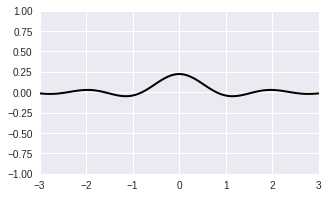

RuntimeError: The animation function must return a sequence of Artist objects.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-3, 3), ylim=(-1, 1))

x = np.linspace(-3, 3, 91)
t = np.linspace(1, 25, 30)
X2, T2 = np.meshgrid(x, t)
 
sinT2 = np.sin(2*np.pi*T2/T2.max())
F = 0.9*sinT2*np.sinc(X2*(1 + sinT2))

line = ax.plot(x, F[0, :], color='k', lw=2)[0]

def animate(i):
    line.set_ydata(F[i, :])
    
anim = FuncAnimation(
    fig, animate, interval=100, frames=len(t)-1, blit=True)
 
plt.draw()
plt.show()

anim.save('testing.mp4')

In [47]:


# define the update function
def update(iv):
    label = 'timestep {0}'.format(iv)
    scat.set_offsets(np.hstack((recog, scores[:,iv])))
    return scat

#first make the matrix and load prepost
subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
variants = ['t', 'f', 't-f', 'c']
ivs = ['trial_num', 'run_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for variant in variants:
        for this_roi in roi_list:

            # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
            # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
            scores = []

            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])

                if variant == 't':
                    score = t
                elif variant == 'f':
                    score = f
                elif variant == 'c':
                    score = c
                else:
                    score = t-f

                if len(scores) == 0:
                    scores = score
                else:
                    scores = np.vstack((scores, score))

            # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
            # in the same order as they are in the matrix.
            recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
            
            # start the plot
            fig, ax = plt.subplots()
            #fig.set_tight_layout(True)
            scat = ax.scatter(recog, scores[:,0])
            
            anim = FuncAnimation(fig, update, frames=np.arange(0, np.shape(scores)[1]), interval=200)
            plt.show()
            break
        break
    break

ValueError: 'vertices' must be a 2D list or array with shape Nx2

In [35]:
np.shape(scores[:,0])

(31,)